まずはライブラリの読み込みを行います。

In [0]:
import math                     # 数学ライブラリ
import numpy as np              # 数値計算用の配列
import matplotlib.pyplot as plt # 可視化ライブラリ

Lorenz and Emanuel (1998, <i>Journal of the Atmospheric Science</i>)のカオス力学系を題材にします。

地球を東西に一周する大気の変動を模したモデルです。
モデルの方程式は以下で与えられます。

dX<sub>j</sub>/dt = (X<sub>j+1</sub> - X<sub>j-2</sub>)X<sub>j-1</sub> - X<sub>j</sub> + F

j = 1..40, 周期境界条件

第一項は波動の伝播、第二項はエネルギー減衰、第三項のFは外部強制力を模していて、Fが4以上になると徐々に非周期解に遷移し、Fが大きいほどカオス的に振る舞います。

In [0]:
class Lorenz96:
  """
  This class provides the Lorenz96 model equations and the 4th-order Runge-Kutta solver.
  """
  def __init__(self, n = 40, f = 8, dt = 0.005, init_x = None):
    self.f = f
    self.dt = dt
    if init_x is not None:
      self.x = init_x
    else:
      self.x = np.zeros(n, dtype=np.float64)
    return
  
  def dx_dt(self, y):
    n = y.shape[0]
    m = n + 3
    tmpx = np.zeros(m, dtype=np.float64)
    tmpx[2:(m - 1)] = y[:]
    # cyclic boundary condition
    tmpx[0:2] = y[(n - 2):n]
    tmpx[m - 1] = y[0]
    val = (tmpx[3:m] - tmpx[0:(m - 3)]) * tmpx[1:(m - 2)] - tmpx[2:(m - 1)] + self.f
    return val

  def runge_kutta(self):
    dx1 = self.dx_dt(self.x)
    x2 = self.x + dx1 * (self.dt * 0.5)
    dx2 = self.dx_dt(x2)
    x3 = self.x + dx2 * (self.dt * 0.5)
    dx3 = self.dx_dt(x3)
    x4 = self.x + dx3 * self.dt
    dx4 = self.dx_dt(x4)
    self.x += (dx1 + 2.0 * (dx2 + dx3) + dx4) * (self.dt / 6.0)
    return self.x


適当な乱数を初期値に与えてモデルを実行し、真値とします。

真値に正規乱数を加えて疑似観測データを生成します。

疑似観測データを別のモデル（同じでも良い）でデータ同化する実験を行います。

Observing System Simulation Experiment (OSSE)と呼びます。

In [0]:
def nature_run(n = 40, f = 8, dt = 0.005, iter = 1000):
  x0 = np.array(np.random.randn(n), dtype=np.float64)
  l96 = Lorenz96(n, f, dt, x0)
  result = []
  for i in range(iter):
    result.append(l96.runge_kutta().copy())
  result = np.array(result)
  return result


真値を作成します。

In [33]:
exp_length = 40 * 365
nature = nature_run(iter = exp_length)
print(nature.shape)


(14600, 40)


作成した真値を可視化してみます

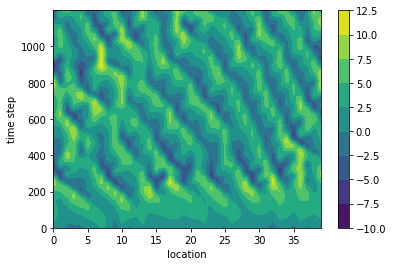

In [34]:
plt.contourf(nature[0:(40 * 30), :])
plt.xlabel('location')
plt.ylabel('time step')
plt.colorbar()

真値に平均0、分散1の正規乱数を加えて疑似観測を作成します

In [0]:
obs_err_std = 1.0
obs = nature + np.random.randn(nature.shape[0], nature.shape[1]) * obs_err_std

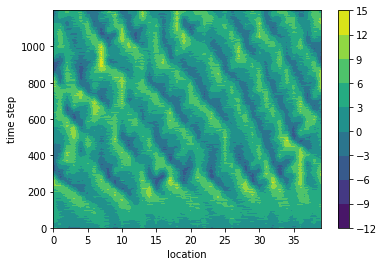

In [36]:
plt.contourf(obs[0:(40 * 30), :])
plt.xlabel('location')
plt.ylabel('time step')
plt.colorbar()

最初の方はモデルが十分に落ち着いていないので捨てます。

In [0]:
n_spinup = 40 * 30
nature = nature[n_spinup:]
obs = obs[n_spinup:]
exp_length -= n_spinup

カルマンフィルタを構築します。以下の式で与えられます。

時刻 i から i + 1 への予報：

x<sup>f</sup><sub>i + 1</sub> = m(x<sup>a</sup><sub>i</sub>) ：状態変数の予報

M<sub>i</sub> = (∂m/∂x)|<sub>(x<sup>a</sup><sub>i</sub></sub>, <sub>x<sup>f</sup><sub>i + 1</sub>)</sub> ：接線型モデル

P<sup>f</sup><sub>i + 1</sub> = M<sub>i</sub>P<sup>a</sup><sub>i</sub>M<sup>T</sup><sub>i</sub> ：予報誤差共分散

時刻 i での解析：

K<sub>i</sub> = P<sup>f</sup><sub>i</sub> H<sup>T</sup><sub>i</sub> (H<sub>i</sub> P<sup>f</sup><sub>i</sub> H<sup>T</sup><sub>i</sub> + R<sub>i</sub>)<sup>-1</sup> ：カルマンゲイン

x<sup>a</sup><sub>i</sub> = x<sup>f</sup><sub>i</sub> + K<sub>i</sub> (y<sup>o</sup><sub>i</sub> - H<sub>i</sub> x<sup>f</sup><sub>i</sub>) ：状態変数の解析

P<sup>a</sup><sub>i</sub> = (I - K<sub>i</sub>H<sub>i</sub>)P<sup>f</sup><sub>i</sub> ：解析誤差共分散

In [0]:
class KalmanFilter:
  def __init__(self, model, n = 40, f = 8, dt = 0.005):
    """
    model: model constructor
    n: model size
    f: external forcing
    dt: time interval of model time integration
    n, f, dt will be passed to the model constructor
    """
    self.n = n
    self.f = f
    self.dt = dt
    # model for the state
    self.model = model(n, f, dt)
    # models to approximate tangent linear model
    self.ensemble = []
    for i in range(n):
      self.ensemble.append(model(n, f, dt))
    # background error covariance matrix
    self.p_f = np.identity(n, dtype=np.float64)
    return
  
  def forward(self):
    """
    This function updates the model state and the background error covariance matrix.
    """
    tmpx = self.model.x.copy()
    # update state
    self.model.runge_kutta()
    # approximate tangent linear model
    eps = 1.0e-8
    m = np.zeros_like(self.p_f)
    for i in range(self.n):
      self.ensemble[i].x[:] = tmpx[:]
      self.ensemble[i].x[i] += eps
      self.ensemble[i].runge_kutta()
      self.ensemble[i].x -= self.model.x
      m[:, i] = self.ensemble[i].x[:]
    m /= eps
    # update background error covariance matrix
    self.p_f = m @ self.p_f @ (m.T)
    return self.model.x, self.p_f

  def analysis(self, h, y, r):
    """
    This function performs the Kalman filtering.
    h: observation operator matrix
    y: a vector of observations
    r: observation error covariance matrix
    """
    if len(self.model.x.shape) == 1:
      xx = self.model.x[:, np.newaxis]
    else:
      xx = self.model.x
    if len(y.shape) == 1:
      yy = y[:, np.newaxis]
    else:
      yy = y
    kalman_gain = self.p_f @ (h.T) @ np.linalg.inv(h @ self.p_f @ (h.T) + r)
    xx += kalman_gain @ (yy - h @ xx)
    self.p_f = (np.identity(self.n, dtype=np.float64) - kalman_gain @ h) @ self.p_f
    return self.model.x, self.p_f

データ同化サイクルを回してみます。

データ同化の頻度は、モデルの時間積分10ステップに1回とします。

（Lorenz96モデルはF=8の時に、0.4無次元時間で誤差が約2倍になります。地球大気では大規模波動（温帯低気圧など）の誤差が2日で倍になる傾向があるため、ここでは0.2無次元時間を1日と考え、通常の気象観測と同様に1日4回観測することにします。）

In [44]:
n = 40 # model size
kf = KalmanFilter(Lorenz96, n)
# set observation error covariance matrix (diagonal)
r = np.identity(n, dtype=np.float64) * obs_err_std
# set observation operator matrix (use identity)
h = np.identity(n, dtype=np.float64)
x = []
analysis_intv = 10
for i in range(exp_length // analysis_intv):
  for j in range(analysis_intv):
    # time (i * analysis_intv + j) to (i * analysis_intv + j + 1)
    xf, pf = kf.forward()
  if (i + 1) * analysis_intv < exp_length:
    print("analysis ", i)
    xa, pa = kf.analysis(h, obs[(i + 1) * analysis_intv, :], r)
    x.append(((i + 1) * analysis_intv, xa.copy()))


analysis  0
analysis  1
analysis  2
analysis  3
analysis  4
analysis  5
analysis  6
analysis  7
analysis  8
analysis  9
analysis  10
analysis  11
analysis  12
analysis  13
analysis  14
analysis  15
analysis  16
analysis  17
analysis  18
analysis  19
analysis  20
analysis  21
analysis  22
analysis  23
analysis  24
analysis  25
analysis  26
analysis  27
analysis  28
analysis  29
analysis  30
analysis  31
analysis  32
analysis  33
analysis  34
analysis  35
analysis  36
analysis  37
analysis  38
analysis  39
analysis  40
analysis  41
analysis  42
analysis  43
analysis  44
analysis  45
analysis  46
analysis  47
analysis  48
analysis  49
analysis  50
analysis  51
analysis  52
analysis  53
analysis  54
analysis  55
analysis  56
analysis  57
analysis  58
analysis  59
analysis  60
analysis  61
analysis  62
analysis  63
analysis  64
analysis  65
analysis  66
analysis  67
analysis  68
analysis  69
analysis  70
analysis  71
analysis  72
analysis  73
analysis  74
analysis  75
analysis  76
analysis 

うまく動いたか、確認します。真値とのずれをL2ノルムの時系列で見てみます。

観測誤差を1.0としているので、それより大きいか小さいか確認します。

Text(0, 0.5, 'root mean square error')

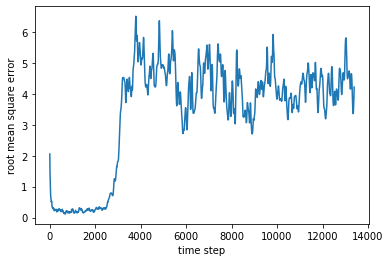

In [45]:
rmse = []
for xx in x:
  if xx[0] < nature.shape[0]:
    rmse.append((xx[0], math.sqrt(((nature[xx[0]] - xx[1]) ** 2).sum() / n)))
rmse = np.array(rmse) 

plt.plot(rmse[:, 0], rmse[:, 1])
plt.xlabel('time step')
plt.ylabel('root mean square error')

最初はうまく動いているように見えますが、途中から悪くなっているのが分かるかと思います。

これは、非線形モデルに対して接線形近似を行って線形最適化問題を解いているため、予報誤差共分散が過小評価される傾向にあるためです。

対策として、予報誤差共分散を人工的に膨張させます（誤差共分散膨張）。

In [48]:
n = 40 # model size
kf = KalmanFilter(Lorenz96, n)
# set observation error covariance matrix (diagonal)
r = np.identity(n, dtype=np.float64) * obs_err_std
# set observation operator matrix (use identity)
h = np.identity(n, dtype=np.float64)
x_new = []
analysis_intv = 10
for i in range(exp_length // analysis_intv):
  for j in range(analysis_intv):
    # time (i * analysis_intv + j) to (i * analysis_intv + j + 1)
    xf, pf = kf.forward()
  if (i + 1) * analysis_intv < exp_length:
    print("analysis ", i)
    # multiplicative covariance inflation
    kf.p_f *= 1.05
    #
    xa, pa = kf.analysis(h, obs[(i + 1) * analysis_intv, :], r)
    x_new.append(((i + 1) * analysis_intv, xa.copy()))


analysis  0
analysis  1
analysis  2
analysis  3
analysis  4
analysis  5
analysis  6
analysis  7
analysis  8
analysis  9
analysis  10
analysis  11
analysis  12
analysis  13
analysis  14
analysis  15
analysis  16
analysis  17
analysis  18
analysis  19
analysis  20
analysis  21
analysis  22
analysis  23
analysis  24
analysis  25
analysis  26
analysis  27
analysis  28
analysis  29
analysis  30
analysis  31
analysis  32
analysis  33
analysis  34
analysis  35
analysis  36
analysis  37
analysis  38
analysis  39
analysis  40
analysis  41
analysis  42
analysis  43
analysis  44
analysis  45
analysis  46
analysis  47
analysis  48
analysis  49
analysis  50
analysis  51
analysis  52
analysis  53
analysis  54
analysis  55
analysis  56
analysis  57
analysis  58
analysis  59
analysis  60
analysis  61
analysis  62
analysis  63
analysis  64
analysis  65
analysis  66
analysis  67
analysis  68
analysis  69
analysis  70
analysis  71
analysis  72
analysis  73
analysis  74
analysis  75
analysis  76
analysis 

結果を確認します。

Text(0, 0.5, 'root mean square error')

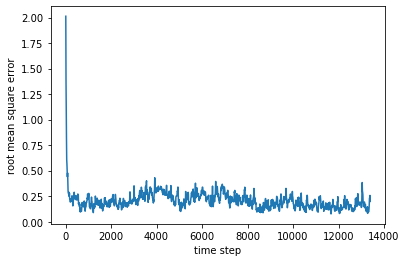

In [49]:
rmse = []
for xx in x_new:
  if xx[0] < nature.shape[0]:
    rmse.append((xx[0], math.sqrt(((nature[xx[0]] - xx[1]) ** 2).sum() / n)))
rmse = np.array(rmse) 

plt.plot(rmse[:, 0], rmse[:, 1])
plt.xlabel('time step')
plt.ylabel('root mean square error')

誤差が低く抑えられていることが分かります。

Lorenz96モデルでカルマンフィルタを動かすと、観測誤差の標準偏差が1.0の場合は、解析root mean square errorは約0.2になります。

つまり、観測誤差よりも解析誤差を小さくすることが出来ます。

次に、カルマンフィルタの肝である、誤差共分散行列を見てみます。

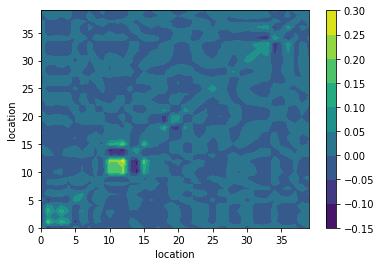

In [51]:
plt.contourf(kf.p_f)
plt.xlabel('location')
plt.ylabel('location')
plt.colorbar()

対称行列で、非対角成分はほとんどの場所で小さいですが、対角成分とその周辺に構造が見えます。

元の予報方程式では、自分の点の前後2点先までを含む式になっています。そのため、対角成分から二つ隣まで、大きな値が入る傾向があります。

この構造が、時々刻々と変化します。それに応じて観測の情報を最適に取り込むことで、精度の高い解析を実現します。

この行列の大きさは、元のモデルの次元の二乗になります。低次元のシステムでは陽に行列を持つことが出来ますが、大次元のシステムでは行列が計算機のメモリーに乗らなくなります。